# Amazon SageMaker를 사용한 물리 로봇의 Roboschool 시뮬레이션

---

## 소개

Roboschool은 가상 로봇 시스템에 대한 RL 정책을 훈련시키는 데 주로 사용되는 [오픈 소스](https://github.com/openai/roboschool/tree/master/roboschool) 물리 시뮬레이터입니다. Roboschool은 물리적 시스템의 3D 시각화를 제공하여 상호간 및 여러 환경과 접촉하는 멀티 조인트를 제공합니다.

이 노트북은 SageMaker RL 컨테이너에 Roboschool을 설치하고 Roboschool에 포함된 사전 구축된(pre-built) 로봇 어플리케이션을 훈련하는 방법을 보여줍니다.

## 해결해야 할 Roboschool 문제 선택

Roboschool은 다양한 로봇 문제에 해당하는 [다양한](https://github.com/openai/roboschool/blob/master/roboschool/__init__.py) gym 환경을 정의합니다. 아래는 다양한 난이도 중 몇 가지를 보여줍니다.

- **Reacher (쉬움)** - 2개의 조인트만 있는 매우 간단한 로봇이 목표물에 도달합니다.
- **호퍼 (중간)** - 한쪽 다리와 발이 달린 간단한 로봇이 트랙을 뛰어 내리는 법을 배웁니다.
- **휴머노이드 (어려움)** - 두 개의 팔, 두 개의 다리 등이 있는 복잡한 3D 로봇은 넘어지지 않고 균형을 잡은 다음 트랙에서 달리는 법을 배웁니다.

간단한 문제들은 적은 계산 리소스 상에서 더 빨리 훈련됩니다. 물론 더 복잡한 문제들은 훈련이 느리지만 더 재미있습니다.

In [1]:
# Uncomment the problem to work on
roboschool_problem = 'reacher'
#roboschool_problem = 'hopper'
#roboschool_problem = 'humanoid'

## 전제 조건(Pre-requisites)

### 라이브러리 임포트

시작하기 위해, 필요한 Python 라이브러리를 가져와서 권한 및 구성을 위한 몇 가지 전제 조건으로 환경을 설정합니다.

In [2]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### S3 버킷 설정

체크포인트(checkpoint) 및 메타데이터에 사용하려는 S3 버킷에 대한 연결 및 인증을 설정합니다.

In [3]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-143656149352/


### 변수 설정

훈련 작업의 작업 접두사(job prefix)와 *컨테이너의 이미지 경로(BYOC 인 경우에만)와 같은 변수*를 정의합니다.

In [4]:
# create a descriptive job name 
job_name_prefix = 'rl-roboschool-'+roboschool_problem

### 훈련이 진행되는 위치 구성

SageMaker 노트북 인스턴스 또는 로컬 노트북 인스턴스를 사용하여 RL 훈련 작업을 훈련할 수 있습니다. 로컬 모드는 SageMaker Python SDK를 사용하여 SageMaker에 배포하기 전에 로컬 컨테이너에서 코드를 실행합니다. 이렇게 하면, 익숙한 Python SDK 인터페이스를 사용하면서 반복 테스트 및 디버깅 속도를 높일 수 있습니다. 여러분은 `local_mode = True` 만 설정하면 됩니다.

In [5]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.c5.2xlarge"

### IAM 역할 생성

SageMaker 노트북 `role = sagemaker.get_execution_role()`을 실행할 때 실행 역할(execution role)을 얻거나 로컬 시스템에서 실행할 때 utils 메소드 `role = get_execution_role()`을 사용하여 실행 역할을 작성하세요.

In [6]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::143656149352:role/service-role/AmazonSageMaker-ExecutionRole-20200323T143836


### `로컬` 모드용 도커 설치

로컬 모드에서 작업하려면 도커(docker)가 설치되어 있어야 합니다. 로컬 머신에서 실행할 때는 docker 또는 docker-compose(로컬 CPU 머신의 경우) 및 nvidia-docker(로컬 GPU 머신의 경우)가 설치되어 있는지 확인하세요. 또는, SageMaker 노트북 인스턴스에서 실행할 때 다음 스크립트를 실행하여 관련 패키지들을 설치할 수 있습니다.

참고로, 한 번에 하나의 로컬 노트북만 실행할 수 있습니다.

In [7]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## 도커 컨테이너 빌드

Roboschool이 설치된 사용자 정의 도커 컨테이너를 빌드해야 합니다. 컨테이너 빌드 작업은 아래 과정을 거쳐 처리됩니다.

1. 기본 컨테이너 이미지 가져오기
2. Roboschool 및 의존성 패키지 설치
3. 새 컨테이너 이미지를 ECR에 업로드

인터넷 연결이 느린 컴퓨터에서 실행 중인 경우, 이 단계에서 시간이 오래 걸릴 수 있습니다. 노트북 인스턴스가 SageMaker 또는 EC2 인 경우 인스턴스 유형에 따라 3-10 분이 걸립니다.

In [8]:
%%time

cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-roboschool-ray-%s" % cpu_or_gpu
docker_build_args = {
    'CPU_OR_GPU': cpu_or_gpu, 
    'AWS_REGION': boto3.Session().region_name,
}
custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using ECR image %s" % custom_image_name)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image sagemaker-roboschool-ray-cpu from Dockerfile
$ docker build -t sagemaker-roboschool-ray-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=us-west-2
Sending build context to Docker daemon  699.4kB
Step 1/14 : ARG CPU_OR_GPU
Step 2/14 : ARG AWS_REGION
Step 3/14 : FROM 520713654638.dkr.ecr.${AWS_REGION}.amazonaws.com/sagemaker-rl-tensorflow:ray0.6.5-${CPU_OR_GPU}-py3
 ---> 2cb0fbd42e4f
Step 4/14 : WORKDIR /opt/ml
 ---> Using cache
 ---> a1aff9d23c92
Step 5/14 : RUN apt-get update && apt-get install -y       git cmake ffmpeg pkg-config       qtbase5-dev libqt5opengl5-dev libassimp-dev       libtinyxml-dev       libgl1-mesa-

## 훈련 코드 작성

훈련 코드는 `/src` 디렉토리에 업로드된 `“train-coach.py”` 파일에 작성됩니다. 먼저 환경 파일과 사전 설정 파일을 가져온 다음, `main()` 함수를 정의하세요.

In [9]:
!pygmentize src/train-{roboschool_problem}.py

import json
import os

import gym
import ray
from ray.tune import run_experiments
from ray.tune.registry import register_env
import roboschool

from sagemaker_rl.ray_launcher import SageMakerRayLauncher


def create_environment(env_config):
    # This import must happen inside the method so that worker processes import this code
    import roboschool
    return gym.make('RoboschoolReacher-v1')


class MyLauncher(SageMakerRayLauncher):

    def register_env_creator(self):
        register_env("RoboschoolReacher-v1", create_environment)

    def get_experiment_config(self):
        return {
          "training": {
            "env": "RoboschoolReacher-v1",
            "run": "PPO",
            "stop": {
              "episode_reward_mean": 18,
            },
            "config": {
              "gamma": 0.995,
              "kl_coeff": 1.0,
              "num_sgd_iter": 20,
              "lr": 0.0001,
              "sgd_minibatch_size": 1000,
              "train_batch_size": 25000,
   

## Python SDK 스크립트 모드를 사용하여 RL 모델 훈련

로컬 모드를 사용하는 경우 노트북 인스턴스에서 훈련이 실행됩니다. 훈련을 위해 SageMaker를 사용할 때 GPU 또는 CPU 인스턴스를 선택할 수 있습니다. RLEstimator는 RL 작업 훈련에 사용됩니다.

1. 환경, 사전 설정 및 교육 코드가 업로드되는 소스 디렉토리를 지정합니다.
2. 엔트리 포인트(entry point)를 훈련 코드로 지정합니다.
3. RL 툴킷 및 프레임 워크를 선택합니다. 이는 RL 컨테이너의 ECR 경로로 자동 확인됩니다.
4. 인스턴스 수, 작업 이름(job name), 출력에 대한 S3 경로 및 작업 이름과 같은 훈련 파라메터들을 정의합니다.
5. RL 에이전트 알고리즘의 하이퍼파라미터를 지정합니다. `RLCOACH_PRESET`을 사용하여 사용하려는 RL 에이전트 알고리즘을 지정할 수 있습니다.
6. [선택 사항] 여러분의 로그에서 캡처할 지표(metric)를 선택합니다. CloudWatch 및 SageMaker Notebook에서도 시각화할 수 있습니다.

In [10]:
%%time

metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)
    
estimator = RLEstimator(entry_point="train-%s.py" % roboschool_problem,
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        hyperparameters={
                          # Attention scientists!  You can override any Ray algorithm parameter here:
                          #"rl.training.config.horizon": 5000,
                          #"rl.training.config.num_sgd_iter": 10,
                        }
                    )

estimator.fit(wait=local_mode)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: rl-roboschool-reacher-2020-03-28-05-05-09-295
CPU times: user 138 ms, sys: 24.4 ms, total: 162 ms
Wall time: 444 ms


## 시각화

RL 훈련에는 시간이 오래 걸릴 수 있습니다. 따라서 훈련 작업이 동작하는 동안 훈련 작업의 진행 상황을 추적할 수 있는 다양한 방법들이 있습니다. 훈련 도중 일부 중간 출력이 S3에 저장되므로, 이를 캡처하도록 설정합니다.

In [11]:
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-roboschool-reacher-2020-03-28-05-05-09-295
S3 job path: s3://sagemaker-us-west-2-143656149352/rl-roboschool-reacher-2020-03-28-05-05-09-295
Intermediate folder path: s3://sagemaker-us-west-2-143656149352/rl-roboschool-reacher-2020-03-28-05-05-09-295/output/intermediate/
Create local folder /tmp/rl-roboschool-reacher-2020-03-28-05-05-09-295


### 훈련 롤아웃 비디오 가져오기

특정 롤아웃의 비디오는 훈련 중 S3에 기록됩니다. 여기에서는 S3에서 마지막 `num_later_videos`개의 비디오 클립을 가져 와서 마지막 비디오를 렌더링합니다.

In [68]:
num_later_videos = 40 
recent_videos = wait_for_s3_object(
            s3_bucket, intermediate_folder_key, tmp_dir, 
            fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), 
            limit=num_later_videos, training_job_name=job_name)

Waiting for s3://sagemaker-us-west-2-143656149352/rl-roboschool-reacher-2020-03-28-05-05-09-295/output/intermediate/...
Only downloading 40 of 84 files


In [69]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Video
import ipywidgets as widgets
video = 0

def showvideo(i):
    last_video = sorted(recent_videos)[i]
    return Video.from_file(last_video)
print(len(recent_videos))

video = interact_manual(showvideo, i=widgets.IntSlider(min=0,max=len(recent_videos)-1,step=1,value=0));
print("i가 증가할 수록(later video) 에이전트가 좀 더 나은 행동을 수행하는 것을 볼 수 있습니다.")

40


interactive(children=(IntSlider(value=0, description='i', max=39), Button(description='Run Interact', style=Bu…

i가 증가할 수록(later video) 에이전트가 좀 더 나은 행동을 수행하는 것을 볼 수 있습니다.


In [67]:
# last_video = sorted(recent_videos)[-1]  # Pick which video to watch
# os.system("mkdir -p ./src/tmp_render_1/ && cp {} ./src/tmp_render_1/last_video.mp4".format(last_video))
# HTML('<video src="./src/tmp_render_1/last_video.mp4" controls autoplay></video>')

### 훈련 작업에 대한 지표 plot

CloudWatch 지표에 기록된 알고리즘 지표를 사용하여 실행 중인 훈련의 보상 지표를 볼 수 있습니다. 시간이 지남에 따라, 모델의 성능을 볼 수 있도록 이를 plot할 수 있습니다.

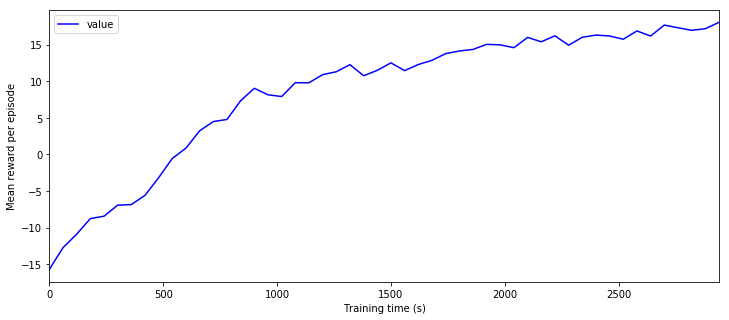

In [60]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

if not local_mode:
    df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
    num_metrics = len(df)
    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch")
    else:
        plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
        plt.set_ylabel('Mean reward per episode')
        plt.set_xlabel('Training time (s)')
else:
    print("Can't plot metrics in local mode.")

### 훈련 진행 상황 모니터링

위의 시각화 셀을 반복해서 실행하여 최신 비디오를 얻거나, 훈련 작업이 진행됨에 따라 최신 지표를 볼 수 있습니다.

## RL 모델 평가
최종 체크포인트 모델을 사용하여 RL 에이전트에 대한 평가를 실행합니다.

### 체크포인트 모델 로드

이전에 훈련된 모델의 체크포인트 데이터는 체크포인트 채널에서 평가/추론을 위해 전달됩니다. 로컬 모드에서는 로컬 디렉토리를 간단하게 사용할 수 있지만, SageMaker 모드에서는 먼저 S3로 이동해야 합니다.

In [ ]:
if local_mode:
    model_tar_key = "{}/model.tar.gz".format(job_name)
else:
    model_tar_key = "{}/output/model.tar.gz".format(job_name)
    
local_checkpoint_dir = "{}/model".format(tmp_dir)

wait_for_s3_object(s3_bucket, model_tar_key, tmp_dir, training_job_name=job_name)  

if not os.path.isfile("{}/model.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File model.tar.gz not found")
    
os.system("mkdir -p {}".format(local_checkpoint_dir))
os.system("tar -xvzf {}/model.tar.gz -C {}".format(tmp_dir, local_checkpoint_dir))

print("Checkpoint directory {}".format(local_checkpoint_dir))

In [ ]:
if local_mode:
    checkpoint_path = 'file://{}'.format(local_checkpoint_dir)
    print("Local checkpoint file path: {}".format(local_checkpoint_dir))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(local_checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(local_checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

In [ ]:
%%time
    
estimator_eval = RLEstimator(entry_point="evaluate-ray.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        base_job_name=job_name_prefix + "-evaluation",
                        hyperparameters={
                            "evaluate_episodes": 5,
                            "algorithm": "PPO",
                            "env": 'Roboschool%s-v1' % roboschool_problem.capitalize()
                        }
                    )

estimator_eval.fit({'model': checkpoint_path})
job_name = estimator_eval.latest_training_job.job_name
print("Evaluation job: %s" % job_name)

### 출력 시각화

선택적으로, 이전에 정의된 step들을 실행하여 출력을 시각화할 수 있습니다.

# 모델 배포

이제 환경 관측에 따라 최적의 조치를 취할 수 있도록 RL 정책을 배포하겠습니다.

In [ ]:
from sagemaker.tensorflow.serving import Model

model = Model(model_data=estimator.model_data,
              role=role)

predictor = model.deploy(initial_instance_count=1, instance_type=instance_type)

In [ ]:
# Mapping of environments to observation space
observation_space_mapping = {"reacher": 9,
                             "hopper": 15,
                             "humanoid": 44}

이제 더미 관측을 사용하여 행동(action)을 예측하겠습니다.

In [ ]:
input = {
  'observations': np.ones((observation_space_mapping[roboschool_problem])),
    
}
result = predictor.predict(input)
result

### 엔드포인트 삭제

In [ ]:
predictor.delete_endpoint()